<a href="https://colab.research.google.com/github/ThisuriLekamge/Stock-Price-Prediction-on-Bitcoin-trading-data-using-LSTM-with-PyTorch/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import glob
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch


In [5]:
#print("python version %s"% python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

pandas==0.25.3
numpy==1.17.4
sklearn==0.21.3
torch==1.3.1
matplotlib==3.1.2


In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"]="w"

**Now download data from BitMex** (The Bitcoin Mercantile Exchange) -> https://www.bitmex.com/app/trade/XBTUSD

**Retrieve bitmex/binance data**
link - https://github.com/BitMEX/easy-data-scripts

https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f



In [3]:
from google.colab import files
uploaded = files.upload()

Saving XBTUSD-5m-data.csv to XBTUSD-5m-data (1).csv


In [0]:
df = pd.read_csv("./XBTUSD-5m-data.csv")

In [11]:
df.shape


(444941, 13)

In [0]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')


In [0]:
df.set_index('timestamp', inplace=True) #set to index


In [14]:
df.head()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2015-09-25 12:05:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:10:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:15:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:20:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:25:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0


In [15]:
df.tail()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2019-12-18 10:05:00+00:00,XBTUSD,6626.5,6627.0,6618.5,6619.5,1867,7701044,6622.0780,50.0,116300429523,1163.004295,7701044.0
2019-12-18 10:10:00+00:00,XBTUSD,6619.5,6623.5,6615.5,6615.5,1395,4672540,6621.2011,622.0,70573830493,705.738305,4672540.0
2019-12-18 10:15:00+00:00,XBTUSD,6615.5,6640.0,6610.0,6629.0,3925,14074759,6628.2230,133.0,212353244058,2123.532441,14074759.0
2019-12-18 10:20:00+00:00,XBTUSD,6629.0,6668.0,6629.0,6643.0,5777,20318419,6648.9362,49917.0,305603710118,3056.037101,20318419.0
2019-12-18 10:25:00+00:00,XBTUSD,6643.0,6643.0,6631.5,6631.5,2070,6060225,6636.1404,2000.0,91325461378,913.254614,6060225.0


The data representation where we group trades by the predefined time interval is called time bars.
https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

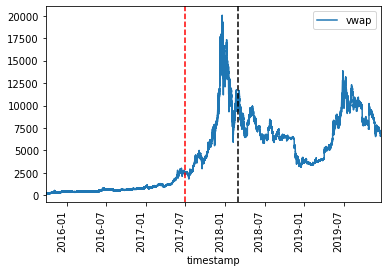

In [19]:

ax = df.plot(y="vwap",rot = 90)
ax.axvline("2018-03-01", linestyle="--", c="black")
ax.axvline("2017-07-01", linestyle="--", c='red')

In [20]:
df_vwap = df.loc[:,["vwap"]]
df_vwap.tail()

,vwap
timestamp,
2019-12-18 10:05:00+00:00,6622.0780
2019-12-18 10:10:00+00:00,6621.2011
2019-12-18 10:15:00+00:00,6628.2230
2019-12-18 10:20:00+00:00,6648.9362
2019-12-18 10:25:00+00:00,6636.1404
